In [1]:
#pip install obspy

In [56]:
import numpy as np
import obspy
from obspy import read
import pandas as pd
import time
import scipy

from __future__ import print_function
import keras
from keras.layers import add, Reshape, Dense,Input, TimeDistributed, Dropout, Activation, LSTM, Conv2D, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l1
from keras import backend as K
from keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import os
np.seterr(divide='ignore', invalid='ignore')
import h5py
#from obspy.signal.trigger import trigger_onset
np.warnings.filterwarnings('ignore')

## Data Preprocess
### Stream generation (no parameter changes)

In [2]:
noise_filename = pd.read_csv('noise.csv', header = None)
noise_stream = []
for i in noise_filename[0]:
    temp = obspy.read("data/noise/" + i)
    noise_stream.append(temp)
    
signal_filename = pd.read_csv('signal.csv', header = None)
signal_stream = []
for i in signal_filename[0]:
    temp = obspy.read("data/signal/" + i)
    signal_stream.append(temp)

In [3]:
def slice_stream(st):
    start_time = st[0].stats.starttime
    end_time = st[0].stats.endtime
    gap = (end_time - start_time)/4
    st = st.slice(start_time + gap, end_time - gap)
    return st

In [4]:
# slice only middle 1000 samples of the stream data
noise_stream = list(map(slice_stream, noise_stream))
signal_stream = list(map(slice_stream, signal_stream))

In [5]:
#band-pass filter between 1 and 45 Hz
noise_stream = [n.filter("bandpass", freqmin=1, freqmax=45) for n in noise_stream]
#resample at 100 HZ
noise_stream = [n.resample(100) for n in noise_stream]
#detrende all the traces by removing the mean
noise_stream = [n.detrend("demean") for n in noise_stream]
#normalize
noise_stream = [n.normalize() for n in noise_stream]

In [6]:
#band-pass filter between 1 and 45 Hz
signal_stream = [n.filter("bandpass", freqmin=1, freqmax=45) for n in signal_stream]
#resample at 100 HZ
signal_stream = [n.resample(100) for n in signal_stream]
#detrende all the traces by removing the mean
signal_stream = [n.detrend("demean") for n in signal_stream]
#normalize
signal_stream = [n.normalize() for n in signal_stream]

In [57]:
length = signal_stream[0][0].stats.endtime - signal_stream[0][0].stats.starttime
signal_stream[0][0].stats.starttime + length/2 -(signal_stream[0][0].stats.starttime + 36*length/61)

-2.884344

### STFT 

In [7]:
f, t, Zxx = signal.stft(signal_stream[0], fs = 100, nperseg=25)

In [9]:
Zxx = np.abs(Zxx).T
Zxx.shape

(248, 13, 3)

In [8]:
# stft of the data 
noise_length = len(noise_stream)
signal_length = len(signal_stream)

f_signal = []
t_signal = []
Zxx_signal = np.zeros(shape = (signal_length, 248, 13, 3))

for i in range(signal_length):
    f, t, Zxx = signal.stft(signal_stream[i], fs = 100, nperseg=25)
    f_signal.append(f)
    t_signal.append(t)
    Zxx_signal[i] = np.abs(Zxx).T

f_noise = []
t_noise = []
Zxx_noise = np.zeros(shape = (noise_length, 248, 13, 3))

for i in range(noise_length):
    f, t, Zxx = signal.stft(noise_stream[i], fs = 100, nperseg=25)
    f_noise.append(f)
    t_noise.append(t)
    Zxx_noise[i] = np.abs(Zxx).T

### ground truth generation (Change dimensions)



In [9]:
## the time lap of the data is about 32 seconds and we would like to set the value at the p-wave arrival time
# and the aftwards data to be 1

noise_y = np.zeros(shape = (noise_length, 62, 1))

signal_y_truth = np.append(np.zeros(shape=(31,1)), np.ones(shape=(31,1)),axis=0)
signal_y = np.zeros(shape = (signal_length, 62, 1))
for i in range(signal_length):
    signal_y[i] = signal_y_truth

In [91]:
np.argwhere(signal_y_truth==1)[0][0]

31

### Combine noise and signal

In [10]:
y = np.append(noise_y, signal_y, axis = 0)
X_Zxx = np.append(Zxx_noise, Zxx_signal, axis = 0)

### Shuffle and split

In [11]:
print(y.shape)
print(X_Zxx.shape)

(19073, 62, 1)
(19073, 248, 13, 3)


In [12]:
np.random.seed(15)
X, X_test, y, y_test = train_test_split(X_Zxx, y, test_size=0.1, random_state=15,shuffle=True)

## CRED Model Training

In [23]:
def lr_schedule(epoch):
    """
    Learning rate is scheduled to be reduced after 40, 60, 80, 90 epochs.
    """
    lr = 1e-2
    if epoch > 60:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [24]:
def block_CNN(filters, ker, inpC): 
    """
    Returns CNN residual blocks
    """
    layer_1 = BatchNormalization()(inpC) 
    act_1 = Activation('relu')(layer_1) 

    conv_1 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_1) 
    
    layer_2 = BatchNormalization()(conv_1) 
    act_2 = Activation('relu')(layer_2) 
  
    conv_2 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_2) 
    return(conv_2)

In [25]:
def block_BiLSTM(inpR, filters, rnn_depth):
    """
    Returns LSTM residual blocks
    """
    x = inpR
    for i in range(rnn_depth):
        x_rnn = Bidirectional(LSTM(filters, return_sequences=True))(x)
        x_rnn = Dropout(0.7)(x_rnn)
        if i > 0 :
            x = add([x, x_rnn])
        else:
            x = x_rnn      
    return x

In [26]:
def model_cred(shape, filters):
    
    inp = Input(shape=shape, name='input')

    conv2D_2 = Conv2D(filters[0], (9,9), strides = (2,2), padding = 'same', activation = 'relu')(inp) 
    res_conv_2 = keras.layers.add([block_CNN(filters[0], 9, conv2D_2), conv2D_2]) 

    conv2D_3 = Conv2D(filters[1], (5,5), strides = (2,2), padding = 'same', activation = 'relu')(res_conv_2) 
    res_conv_3 = keras.layers.add([block_CNN(filters[1], 5, conv2D_3),conv2D_3]) 
    
    shape = K.int_shape(res_conv_3)   
    reshaped = Reshape((shape[1], shape[2]*shape[3]))(res_conv_3)
    
    res_BIlstm = block_BiLSTM(reshaped, filters = filters[3], rnn_depth = 2)
 
    UNIlstm = LSTM(filters[3], return_sequences=True)(res_BIlstm)
    UNIlstm = Dropout(0.8)(UNIlstm)  
    UNIlstm = BatchNormalization()(UNIlstm)
   
    dense_2 = TimeDistributed(Dense(filters[3], kernel_regularizer=l1(0.01), activation='relu'))(UNIlstm)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(0.8)(dense_2)
    
    dense_3 = TimeDistributed(Dense(1, kernel_regularizer=l1(0.01), activation='sigmoid'))(dense_2)

    out_model = Model(inputs=inp, outputs=dense_3)
    return out_model

In [27]:
early_stopping_monitor = EarlyStopping(patience=5)
    
lr_scheduler = LearningRateScheduler(lr_schedule)
    
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5-2,
                                   min_lr=0.5e-7)

In [28]:
model = model_cred((248, 13, 3), filters = [8, 16, 32, 64, 128, 256])
model.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(lr=lr_schedule(0)),
                  metrics=['binary_accuracy'])
model.summary()

Learning rate:  0.01
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 248, 13, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 124, 7, 8)    1952        ['input[0][0]']                  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 124, 7, 8)   32          ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                       

In [29]:
seed_value = 15
tf.random.set_seed(seed_value)

In [30]:
checkpointer = ModelCheckpoint(filepath='model_best.hdf5',
                                       monitor='val_loss', verbose=0, mode='auto', save_best_only=True)
start_time = time.time()  
history = model.fit(
    X,
    y,
    epochs=200,
    batch_size=500,
    verbose=0,
    validation_split = 0.2,
    max_queue_size=5,
    callbacks = [checkpointer, lr_reducer, lr_scheduler, early_stopping_monitor] )
end_time = time.time()

Learning rate:  0.01


2022-03-07 11:58:43.691666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:44.760700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:44.889712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:45.299495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:45.345870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:45.722862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 11:58:46.103633: I tensorflow/core/grappler/optimizers/cust

Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05


In [31]:
history.history['val_binary_accuracy']

[0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9888887405395508,
 0.9711622595787048,
 0.9711622595787048,
 0.9711622595787048,
 0.9907774329185486,
 0.9937466979026794,
 0.9935775399208069,
 0.9938265681266785,
 0.9952595233917236,
 0.996551513671875,
 0.9961568713188171,
 0.9967817664146423,
 0.9972093105316162,
 0.9977495670318604,
 0.9978764653205872,
 0.9979704022407532,
 0.9983086585998535,
 0.998412013053894,
 0.9982993006706238,
 0.9983744621276855,
 0.9984778165817261,
 0.998412013053894,
 0.9984543323516846,
 0.9984261393547058,
 0.9984402060508728,
 0.9985905885696411,
 0.9986328482627869,
 0.9986281394958496,
 0.9986234307289124,
 0.9986469745635986,
 0.9986375570297241,
 0.9986234307289124,
 0.9986093640327454,
 0.9986234307289124,
 0.9986422657966614,
 0.9985952973365784,
 0.9986281394958496,
 0.9986093640327

# Detection 

In [74]:
def label(prob):
    prediction = np.zeros(shape = prob.shape)
    for i in range(len(prob)):
        if prob[i] > 0.8:
            prediction[i] = 1
    return prediction

In [95]:
def Confusion_Matrix(test_array, y_true_array):
    '''
    The function is designed to create a confusion matrix about whether the signal is correctly detected
    ----------------------------------
    Input:
    test_array: a list of stream that to be detected, the stream should have three channel
    y_true_array: the ground truth of the corresponding stream in the test_list
    ----------------------------------
    Output:
    return: a confusion matrix of the model, each row of the matrix corresponds to a predicted class and 
            each column of the matrix corresponds to an actual class

    '''
    matrix = pd.DataFrame(data = np.zeros(shape = (2,2)), columns = ['Signal', 'Noise'], index = ['Signal', 'Noise'])
    y_prob_array = model.predict(test_array)
    for i in range(len(y_prob_array)):
        y_pred = label(y_prob_array[i])
        truth = y_true_array[i]
        if np.any(y_pred == 1) & np.any(truth == 1):
            matrix.iloc[0,0] += 1
        elif np.any(y_pred == 1) & np.all(truth == 0):
            matrix.iloc[0,1] += 1
        elif np.all(y_pred == 0) & np.any(truth == 1):
            matrix.iloc[1,0] += 1
        elif np.all(y_pred == 0) & np.all(truth == 0):
            matrix.iloc[1,1] += 1
    return matrix

In [96]:
Confusion_Matrix(X_test, y_test)

,Signal,Noise
Signal,117.0,1.0
Noise,1.0,1789.0


In [38]:
def detection(st):
    '''
    ----------------------------------
    Input:
    st: the input should be a wave stream with the same scale of the training data, which is three chanel of the wave,
        in which channel there are 2000 data points
    ----------------------------------
    Output:
    return: time detected time of p-wave arrival; and if there is no signal, print('No p-wave signal') and return None
    '''
    # input process part
    st = slice_stream(st)
    st = st.filter("bandpass", freqmin=1, freqmax=45)
    st = st.resample(100)
    st = st.detrend("demean")
    st = st.normalize()
    
    # stft
    f, t, Zxx = signal.stft(st, fs = 100, nperseg=25)
    Zxx = np.abs(Zxx).T
    
    # input into model
    model.load_weights('model_best.hdf5')
    y = model.predict(Zxx)
    
    # time output
    if np.all(y == 0):
        print("No p-wave signal")
        return None
    else:
        t = np.argwhere(y==1)[0][0] ## get the index of the first '1' appear in the prediction
        lap = st[0].stats.endtime - st[0].stats.starttime
        arrival_time = st[0].stats.starttime + lap / 61 * (t-1)
        return arrival_time


In [39]:
y_pred = model.predict(X_test)

2022-03-07 13:33:08.997490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:33:10.223070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:33:10.256331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:33:10.681702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:33:10.695966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:33:10.908078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [73]:
y_probility = y_pred[200]
len(y_probility)

62

In [75]:
label(y_probility)

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

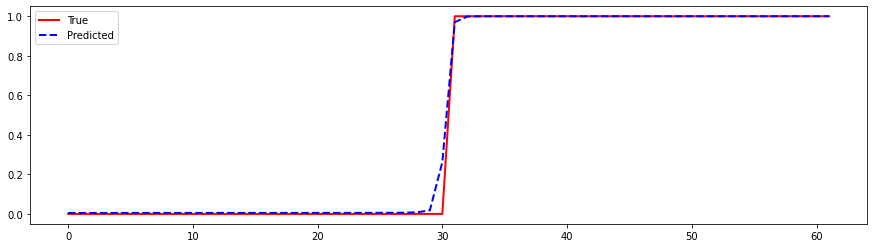

In [65]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(y_test[200].squeeze(), color='r', linewidth=2, label='True')
plt.plot(y_pred[200].squeeze(),'--', color='b', linewidth=2, label='Predicted')
plt.legend()
plt.show()